In [40]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
import torch
import supervision as sv
import pytorch_lightning as pl
import cv2

In [42]:
from transformers import DetrImageProcessor, DetrForObjectDetection

In [43]:
import os
from pathlib import Path
import json
from PIL import Image

In [44]:
### CONFIG

CSV_PATH = Path("../data/train_solution_bounding_boxes.csv")
TRAIN_IMAGE_DIR = Path('../data/training_images')
OUTPUT_TRAIN_JSON_PATH = os.path.join(TRAIN_IMAGE_DIR, 'annotations_coco.json')

In [45]:
train = pd.read_csv(CSV_PATH)

In [46]:
CSV_PATH

PosixPath('../data/train_solution_bounding_boxes.csv')

prepping coco dataset

In [47]:
# Prepare coco format
coco = {
    "images": [],
    "annotations": [],
    "categories": [
        {
            "id": 1,
            "name": "car",
            "supercategory": "vehicle"
        }
    ]
}

In [48]:
#Map the image filename to image id
image_id_map = {}
annotation_id = 1
image_id_counter = 1

images = train['image'].unique()

images

array(['vid_4_1000.jpg', 'vid_4_10000.jpg', 'vid_4_10040.jpg',
       'vid_4_10020.jpg', 'vid_4_10060.jpg', 'vid_4_10100.jpg',
       'vid_4_10120.jpg', 'vid_4_10140.jpg', 'vid_4_1020.jpg',
       'vid_4_1040.jpg', 'vid_4_10480.jpg', 'vid_4_10500.jpg',
       'vid_4_10520.jpg', 'vid_4_1060.jpg', 'vid_4_10960.jpg',
       'vid_4_10980.jpg', 'vid_4_11000.jpg', 'vid_4_11020.jpg',
       'vid_4_11240.jpg', 'vid_4_11260.jpg', 'vid_4_11280.jpg',
       'vid_4_11380.jpg', 'vid_4_11400.jpg', 'vid_4_11420.jpg',
       'vid_4_11440.jpg', 'vid_4_11900.jpg', 'vid_4_11880.jpg',
       'vid_4_11920.jpg', 'vid_4_11940.jpg', 'vid_4_11960.jpg',
       'vid_4_11980.jpg', 'vid_4_12000.jpg', 'vid_4_12040.jpg',
       'vid_4_12100.jpg', 'vid_4_12060.jpg', 'vid_4_12080.jpg',
       'vid_4_12120.jpg', 'vid_4_12140.jpg', 'vid_4_12160.jpg',
       'vid_4_12180.jpg', 'vid_4_12200.jpg', 'vid_4_12220.jpg',
       'vid_4_12240.jpg', 'vid_4_12260.jpg', 'vid_4_12280.jpg',
       'vid_4_12300.jpg', 'vid_4_12320.jpg',

In [49]:
for img_name in images:
    img_path = os.path.join(TRAIN_IMAGE_DIR, img_name)
    if not os.path.exists(img_path):
        print(f'Warning: {img_path} not found!')
        continue
    with Image.open(img_path) as img:
        width, height = img.size
    # add image's info to coco
    image_info = {
        "file_name": img_name,
        "height": height,
        "width": width,
        "id": image_id_counter
    }
    coco['images'].append(image_info)
    image_id_map[img_name] = image_id_counter
    image_id_counter += 1

In [50]:
# process annotations
for idx, row in train.iterrows():
    img_name = row['image']
    if img_name not in image_id_map:
        continue # if the image is missing, then skip annotation
    x_min = row['xmin']
    y_min = row['ymin']
    x_max = row['xmax']
    y_max = row['ymax']

    # now to coco box format
    bbox_width = x_max - x_min
    bbox_height = y_max - y_min

    annotation = {
        "id": annotation_id,
        "image_id": image_id_map[img_name],
        "category_id": 1, # car
        "bbox": [x_min, y_min, bbox_width, bbox_height],
        "area": bbox_width * bbox_height,
        "iscrowd": 0,
        "segmentation": []
    }
    coco['annotations'].append(annotation)
    annotation_id += 1

In [51]:
with open(OUTPUT_TRAIN_JSON_PATH, 'w') as f:
    json.dump(coco, f, indent = 4)
print(f'Coco annotations saved to {OUTPUT_TRAIN_JSON_PATH}')

Coco annotations saved to ../data/training_images/annotations_coco.json


Training

In [52]:


image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [53]:
ANNOTATION_FILE_NAME = 'annotations_coco.json'

In [54]:
os.path.join(TRAIN_IMAGE_DIR, ANNOTATION_FILE_NAME)

'../data/training_images/annotations_coco.json'

In [55]:
import torchvision
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(TRAIN_IMAGE_DIR, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(TRAIN_IMAGE_DIR, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {
            "image_id": image_id,
            "annotations": annotations
        }
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors = 'pt')
        pixel_values = encoding['pixel_values'].squeeze()
        target = encoding['labels'][0]
        return pixel_values, target

In [56]:
TRAIN_DATASET = CocoDetection(
    image_directory_path = TRAIN_IMAGE_DIR, image_processor=image_processor,
    train = True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [57]:
print(f'Number of training examples: {len(TRAIN_DATASET)}')

Number of training examples: 355


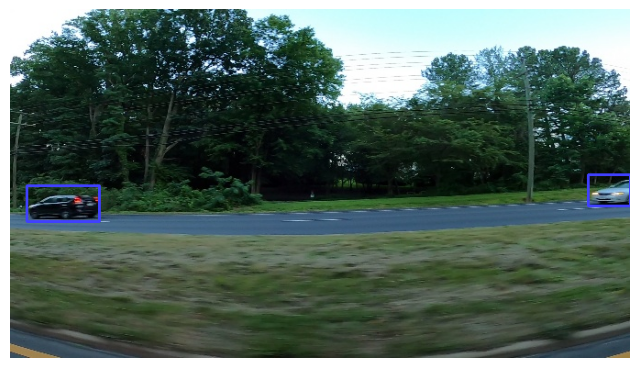

In [58]:
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])


image = cv2.imread(image_path)
if image is None:
    print(f"[ERROR] Failed to load image: {image_path}")
else:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    xyxy = []
    class_ids = []

    for ann in annotations:
        x, y, w, h = ann['bbox']
        xyxy.append([x, y, x + w, y + h])
        class_ids.append(ann['category_id'])

    categories = TRAIN_DATASET.coco.cats
    id2label = {k: v['name'] for k, v in categories.items()}
    labels = [id2label[cid] for cid in class_ids]

    detections = sv.Detections(
        xyxy=np.array(xyxy, dtype=np.float32),
        class_id=np.array(class_ids),
        data={"label": labels}
    )

    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)

    plt.figure(figsize=(8, 8))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.show()

In [59]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors = 'pt')
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)

In [60]:
class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here:
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

In [61]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [62]:
from pytorch_lightning import Trainer

# settings
MAX_EPOCHS = 10

trainer = Trainer( max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5)

trainer.fit(model)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.007   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode
/Users/abilfad/Documents/code/cv_task_pnu/cv_task/lib/python3.12/site-packages/pytorch_lightning/tra

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [63]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cpu')

In [64]:
MODEL_PATH = 'car-object-detection-detr-finetuned_iter_1'
model.model.save_pretrained(MODEL_PATH)

# loading model
model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
model.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [65]:
def load_model(model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Load the trained DETR model for inference"""

    # Load the model
    model = DetrForObjectDetection.from_pretrained(model_path)
    model.to(device)
    model.eval()  # Set to evaluation mode

    # Load the image processor
    image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    print(f"Model loaded from {model_path} on device: {device}")
    return model, image_processor

In [66]:
# Load model
MODEL_PATH = 'car-object-detection-detr-finetuned_iter_1'
model, image_processor = load_model(MODEL_PATH, DEVICE)

Model loaded from car-object-detection-detr-finetuned_iter_1 on device: cpu


In [101]:
def detect_cars_in_image(image_path, model, image_processor, device, confidence_threshold=0.01):
    """
    Detect cars in a single image

    Args:
        image_path: Path to the image file
        model: Loaded DETR model
        image_processor: DETR image processor
        device: Device to run inference on
        confidence_threshold: Minimum confidence score for detections

    Returns:
        detections: Supervision detections object
        annotated_image: Image with bounding boxes drawn
    """

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = image_processor(images=image, return_tensors="pt").to(device)

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert outputs to detections
    target_sizes = torch.tensor([image.size[::-1]]).to(device)  # (height, width)
    results = image_processor.post_process_object_detection(
        outputs, target_sizes=target_sizes, threshold=confidence_threshold
    )[0]

    # Extract bounding boxes, scores, and labels
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    labels = results["labels"].cpu().numpy()

    # Convert to supervision format for visualization
    detections = sv.Detections(
        xyxy=boxes,
        confidence=scores,
        class_id=labels
    )

    # Annotate image
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Create labels with confidence scores
    labels_text = [f"car: {score:.2f}" for score in scores]

    annotated_image = box_annotator.annotate(scene=image_cv.copy(), detections=detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image,
        detections=detections,
        labels=labels_text
    )

    return detections, cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)


In [102]:
def run_inference_pipeline():
    """Complete example of loading model and running inference"""

    # Configuration
    MODEL_PATH = 'car-object-detection-detr-finetuned_iter_1'
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    CONFIDENCE_THRESHOLD = 0.02

    # Load model
    model, image_processor = load_model(MODEL_PATH, DEVICE)

    # Example 1: Single image inference
    image_path = "../data/testing_images/vid_5_26580.jpg"  # Replace with actual path
    if os.path.exists(image_path):
        detections, annotated_image = detect_cars_in_image(
            image_path, model, image_processor, DEVICE, CONFIDENCE_THRESHOLD
        )

        # Display results
        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_image)
        plt.axis('off')
        plt.title(f'Detected {len(detections)} cars')
        plt.show()

        # Print detection details
        print(f"Number of cars detected: {len(detections)}")
        for i, (box, conf) in enumerate(zip(detections.xyxy, detections.confidence)):
            print(f"Car {i+1}: Bbox={box}, Confidence={conf:.3f}")

Model loaded from car-object-detection-detr-finetuned_iter_1 on device: cpu


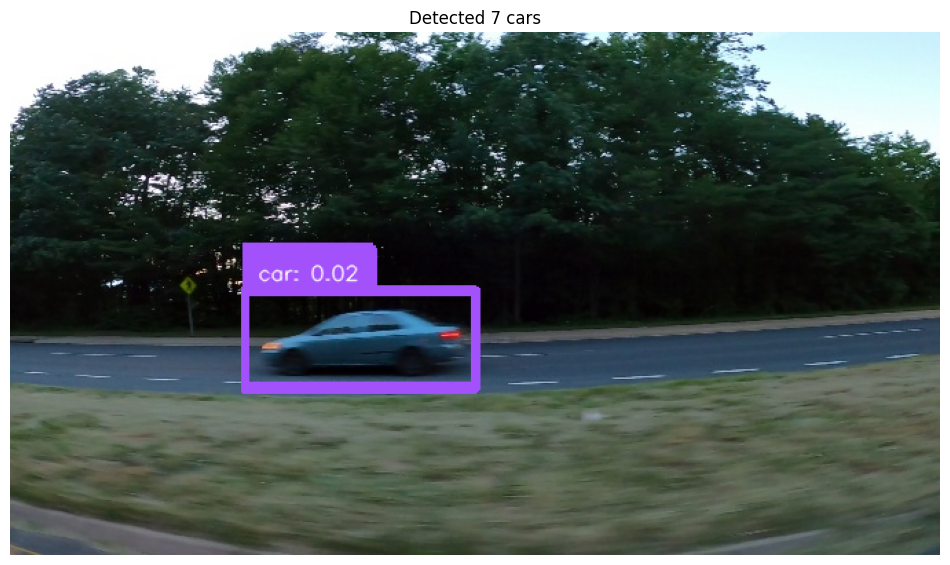

Number of cars detected: 7
Car 1: Bbox=[171.68803 187.58978 336.64124 256.73718], Confidence=0.020
Car 2: Bbox=[170.35176 190.18643 339.2814  255.08679], Confidence=0.020
Car 3: Bbox=[172.00703 189.0177  336.09756 256.20523], Confidence=0.022
Car 4: Bbox=[171.13652 190.01193 338.5957  256.6994 ], Confidence=0.021
Car 5: Bbox=[169.10077 186.9626  340.89236 259.87717], Confidence=0.020
Car 6: Bbox=[169.0668  185.98726 338.64645 261.5816 ], Confidence=0.021
Car 7: Bbox=[170.22018 190.98772 340.70398 255.34656], Confidence=0.020


In [103]:
run_inference_pipeline()